### Importer toutes les librairies

In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
# Input : instancie un tenseur symbolique
# Dense : Une couche de réseaux de neurones ou chaque entrée est connecté à tous les neurones.
# Flatten : Une couche où les données d'entrées sont converties en un tableau unidimensionnel créeant ainsi un seul long vecteur de caractéristiques.
# Dropout : Abandonne des neurones dans un réseau de neurones suivant une probabilité supérieur à 0.

from tensorflow.keras.models import Model, load_model
# Model : Cet objet regroupe les couches avec des fonctions d'apprentissage et d'inférence.
# load_model : Charger un modèle

from tensorflow.keras.applications import VGG19
# VGG19 est un modèle composé de 19 couches :
# 16 couches de convolution;
# 3 couches entièrement connectées; 
# 5 couches MaxPool;
# 1 couche SoftMax.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Génére des lots de données d'image de tenseur avec une augmentation de données en temps réel.

from tensorflow.keras.utils import to_categorical
# Convertit un vecteur de classe (entiers) en matrice de classe binaire.

from sklearn.metrics import confusion_matrix, roc_curve
# Bilbiothèque python de machine learning développé par des instituts français comme l'INRIA

# confusion_matrix : calculer la matrice de confusion pour évaluer l'exactitude d'une classification.

# roc_curve : La fonction roc_curve calcule la courbe caractéristique de fonctionnement du récepteur, 
# ou courbe ROC illustrant les performances d'un système de classificateur binaire.

from sklearn.model_selection import train_test_split

# Divise des tableaux ou des matrices en sous-ensembles d'entraînement et de test aléatoires.

from sklearn.preprocessing import LabelBinarizer
# Binarisez les étiquettes de manière un contre tous un classificateur binaire 
# pour chaque résultat possible de N classifieurs.

import seaborn as sns
import matplotlib.pyplot as plt
# Seaborn est une bibliothèque qui associée à Matplotlib permet la création de graphiques.

import numpy as np
# Une bibliothèque de manipulation de matrices ou tableaux multidimensionnels.

from glob import glob
# Une bibliothèque dédiée à la recherche de chemin de type unix.

import pandas as pd
# Une bibliothèque de manipulation et d'analyse des données proposant en particulier des structures de données 
# et des opérations de manipulation de tableaux numériques et de séries temporelles.

import cv2
# Une bibliothèque (OpenCV) spécialisée dans le traitement d'images.

### Définir quelques paramètres :

In [6]:
IMAGE_SIZE = [224, 224]
# Les dimensions communes à toutes les images :
epochs = 10
# nombre d'époques pour entraîner le modèle.
batch_size = 32
# Un ensemble de données trop important oblige à découper les données en lots dont la taille est précisé par la variable batch_size.
# Une relation existe entre la taille de l'ensemble de données (data_size), le nombre d'époques (epochs_number), la taille des lots (batch_size) et le nombre d'itérations (iteration_number) tel que :
# data_size * epochs_number = batch_size * iteration_number

# Définir les emplacements du dataset :
tumor_path = '/Users/patrice/Datasets/Brain Tumor/yes'
non_tumor_path = '/Users/patrice/Datasets/Brain Tumor/no'

# Glob permet de récupérer l'emplacement des images présentes dans le dataset :
tumor_files = glob(tumor_path + '/*')
non_tumor_files = glob(non_tumor_path + '/*')

# Créer des listes d'images et d'étiquettes à partir des fichiers images :
tumor_images=[]
tumor_labels=[]

non_tumor_images=[]
non_tumor_labels=[]

for i in range(len(tumor_files)):
    image = cv2.imread(tumor_files[i])
    # La méthode imread renvoie une image chargée à partir du fichier spécifié.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Conversion de l'espace colorimétrique, le paramètre COLOR_BGR2RGB indique que BGR est converti en RVB.
    image = cv2.resize(image,(224,224))
    # redimensionner l'image en 224 x 224 (largeur x hauteur)
    tumor_images.append(image)
    # Ajout de l'image dans la liste dénommée tumor_images
    tumor_labels.append('Tumeur détectée')
    # Ajout d'un label pour chaque image

for i in range(len(non_tumor_files)):
  image = cv2.imread(non_tumor_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  non_tumor_images.append(image)
  non_tumor_labels.append('Aucune tumeur détectée')

print(f"Dataset ne présentant pas de tumeur - Nombre d'images : {len(non_tumor_images)}")
print(f"Dataset présentant une tumeur - Nombre d'images : {len(non_tumor_images)}")

Dataset ne présentant pas de tumeur - Nombre d'images : 98
Dataset présentant une tumeur - Nombre d'images : 98


### Visualiser les 24 premières images de l'ensemble de données

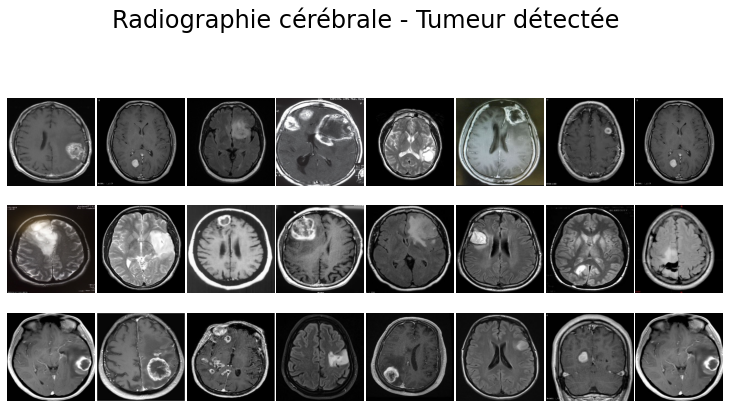

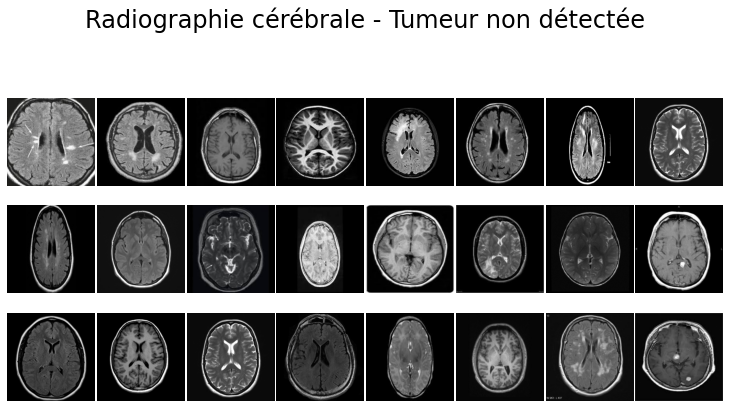

In [7]:
def plot_images(images, title):
    nrows, ncols = 3, 8
    # Le nombre de lignes et de colonnes
    figsize = [10, 6]
    # La taille de la figure

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
    # Créez une figure et un ensemble de sous-parcelles.
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        # Afficher les images
        axi.set_axis_off()
        # Désactive les axes x et y

    plt.suptitle(title, fontsize=24)
    # Affichage du titre
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    # Ajuste automatiquement les paramètres de sous-parcelle
    plt.show()
    # Affiche la figure à l'écran
    
plot_images(tumor_images, "Radiographie cérébrale - Tumeur détectée")
plot_images(non_tumor_images, 'Radiographie cérébrale - Tumeur non détectée')

### **Conversion et normalisation**

In [8]:
# Conversion des images sous la forme d'un tableau et normalisation en intervalle de [0,1]

# Intérêt de la normalisation :
# Il s'agit d'une préparation de données qui consiste à mettre à l'échelle l'ensemble des données entre 0 et 1 en divisant /255.
# Le but est d'éviter que certaines valeurs deviennent trop influente par rapport à d'autres.

tumor_images = np.array(tumor_images) / 255
non_tumor_images = np.array(non_tumor_images) / 255

### Séparation de jeux d'essai

In [9]:
# Diviser l'ensemble de données en deux : un ensemble d'entrainement (80 %) et un ensemble de test (20%) :

tumor_x_train, tumor_x_test, tumor_y_train, tumor_y_test = train_test_split(
    tumor_images, tumor_labels, test_size=0.2)
# L'ensemble d'entrainement et de test des images présentant une tumeur.

non_tumor_x_train, non_tumor_x_test, non_tumor_y_train, non_tumor_y_test = train_test_split(
    non_tumor_images, non_tumor_labels, test_size=0.2)
# L'ensemble d'entrainement et de test des images ne présentant pas de tumeur.

# Concaténation de ensemble X et y
X_train = np.concatenate((non_tumor_x_train, tumor_x_train), axis=0)
X_test = np.concatenate((non_tumor_x_test, tumor_x_test), axis=0)
y_train = np.concatenate((non_tumor_y_train, tumor_y_train), axis=0)
y_test = np.concatenate((non_tumor_y_test, tumor_y_test), axis=0)
# y_train et y_test contiennent les étiquettes de classe 
# mentionnant la présence ou non de tumeur pour X_train et X_test

# Transformer les étiquettes en catégories - 0 ou 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

# LabelBinarizer : binarisez les étiquettes de manière un contre tous un classificateur binaire 
# pour chaque résultat possible de N classifieurs.
# to_categorical : convertit un vecteur de classe (entiers) en matrice de classe binaire.

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualisez quelques images des ensembles d'entraînement et de test

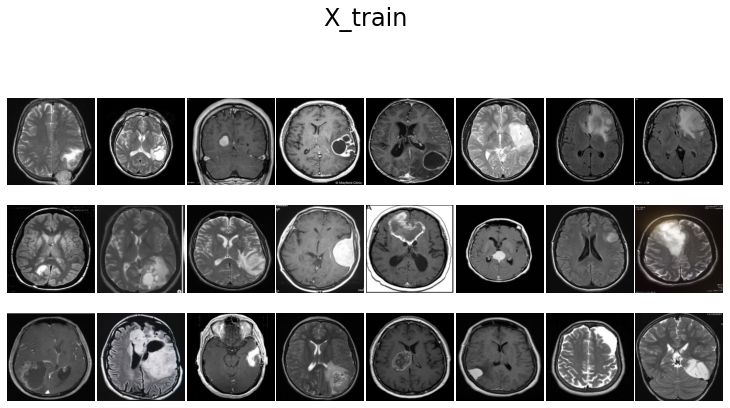

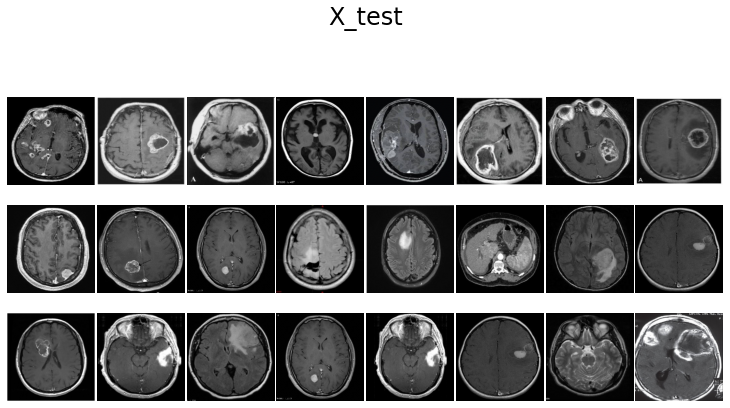

In [10]:
plot_images(tumor_x_train, 'X_train')
plot_images(tumor_x_test, 'X_test')

### **Building and Visualizing model**

In [7]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# weights : 
# - None : initialisation aléatoire des poids, 
# - 'imagenet' Les poids sont pré-formés sur ImageNet,
# - ou proposer un chemin vers le fichier de poids à charger.

# include_top : 
# True : inclut les trois couches dernières couches Dense 
# en haut du réseau (le réseau est intégré dans une pile)
# sinon False

# Input() instancie un tenseur.
# shape : un tuple de forme (entiers), n'incluant pas la taille du lot.

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
# Flatten : une couche où les données d'entrées sont converties en un tableau unidimensionnel 
# créeant ainsi un seul long vecteur de caractéristiques.

outputs = Dropout(0.2)(outputs)
# Dropout : abandonne des neurones dans un réseau de neurones suivant une probabilité supérieur à 0.

outputs = Dense(2, activation="softmax")(outputs)
# Dense : Une couche de réseaux de neurones ou chaque entrée est connecté à tous les neurones.

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False
# Le réglage layer.trainable sur False rend toutes les pondérations des couches de VGG19 non entraînables.
# en d'autres termes les couches du VGG19 sont dites "geler".

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
# categorical_crossentropy : calcule la perte d'entropie croisée entre les étiquettes (donc les valeurs réelles) et les prédictions
# lorsqu'il existe deux classes d'étiquettes ou plus.

# optimizer='adam' : l'optimisation d'Adam est une méthode de descente de gradient stochastique basée sur l'estimation adaptative des moments de premier et de second ordre.
# Selon Kingma et al., 2014 , la méthode est " efficace en termes de calcul, nécessite peu de mémoire, est invariante au redimensionnement diagonal des gradients et convient bien aux problèmes de grande taille en termes de données/paramètres ".
# https://keras.io/api/optimizers/adam/

# metrics=['accuracy'] : calcule la fréquence à laquelle les prédictions correspondent aux libellés.

In [8]:
model.summary()
# Imprime un résumé de chaîne du réseau.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### **Augmentation de données**
Pour s'entraîner sur des images à différentes positions, angles, retournements

In [9]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True,
)
# ImageDataGenerator : Génére des lots de données d'image de tenseur avec une augmentation de données en temps réel.

# rotation_range : plage de degrés pour les rotations aléatoires.
# width_shift_range et height_shift_range : fraction de la largeur ou de la hauteur totale  redimensionner aléatoirement des images verticalement ou horizontalement.
# horizontal_flip : inversez aléatoirement les entrées horizontalement.

### **Entrainement du modèle**

In [10]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(X_train) / 32,
                    validation_steps=len(X_test) / 32,
                    epochs=15)

# validation_data : données sur lesquelles évaluer la perte et toute métrique de modèle à la fin de chaque époque. 
# Le modèle ne sera pas formé sur ces données. 
# Cela peut être une liste (x_val, y_val) ou une liste (x_val, y_val, val_sample_weights).

# steps_per_epoch : nombre total d'étapes (lots d'échantillons) avant de déclarer une époque terminée et de commencer l'époque suivante. 
# Lors de l'entraînement avec des tenseurs d'entrée tels que les tenseurs de données TensorFlow, la valeur par défaut NULL 
# est égale au nombre d'échantillons dans votre ensemble de données divisé par la taille du lot, ou 1 si cela ne peut pas être déterminé.

# validation_steps : pertinent uniquement si steps_per_epoch est spécifié. 
# Nombre total d'étapes (lots d'échantillons) à valider avant d'arrêter.

# epochs : nombre d'époques pour former le modèle.

# https://keras.rstudio.com/reference/fit.html

2022-02-10 14:01:17.217148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-10 14:01:17.218754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
6/6 [==============================] - 61s 10s/step - loss: 2.0770 - accuracy: 0.5396 - val_loss: 1.6475 - val_accuracy: 0.6078
Epoch 2/15
6/6 [==============================] - 62s 10s/step - loss: 1.2222 - accuracy: 0.5495 - val_loss: 0.5157 - val_accuracy: 0.7451
Epoch 3/15
6/6 [==============================] - 62s 10s/step - loss: 0.6870 - accuracy: 0.7376 - val_loss: 0.3694 - val_accuracy: 0.8235
Epoch 4/15
6/6 [==============================] - 60s 10s/step - loss: 0.5440 - accuracy: 0.7723 - val_loss: 0.6752 - val_accuracy: 0.7451
Epoch 5/15
6/6 [==============================] - 60s 10s/step - loss: 0.6612 - accuracy: 0.7723 - val_loss: 0.4079 - val_accuracy: 0.8431
Epoch 6/15
6/6 [==============================] - 62s 10s/step - loss: 0.4592 - accuracy: 0.8069 - val_loss: 0.6336 - val_accuracy: 0.7843
Epoch 7/15
6/6 [==============================] - 62s 10s/step - loss: 0.4363 - accuracy: 0.8020 - val_loss: 0.3459 - val_accuracy: 0.8431
Epoch 8/15
6/6 [===========

In [11]:
# https://stackoverflow.com/questions/51704808/what-is-the-difference-between-loss-accuracy-validation-loss-validation-accur
model.save('vgg_tumor2.h5')
# Sauvegarde du modèle sous la forme d'un fichier .h5 
# Format de fichier intégrant des données de type tableaux multidimensionnels.

In [12]:
model.save_weights('vggweights_tumor2.hdf5')
# Sauvegarde des poids sous la forme d'un fichier .hdf5

In [11]:
model = load_model('vgg_tumor.h5')
# Charger le modèle

### Visualiation de quelques prédictions

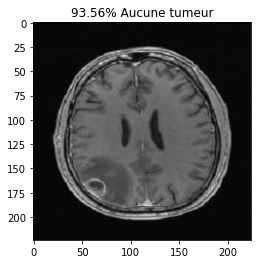

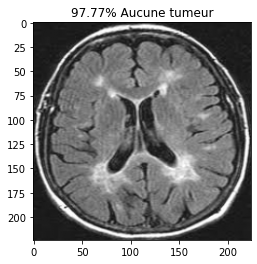

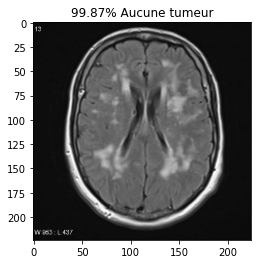

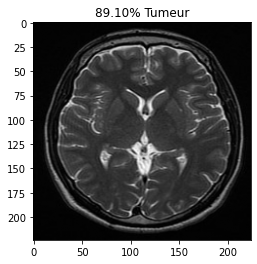

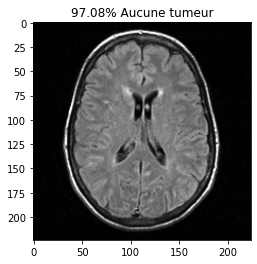

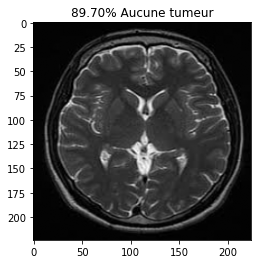

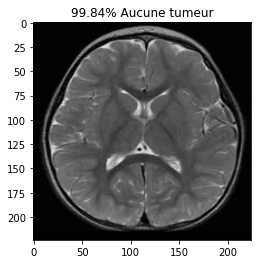

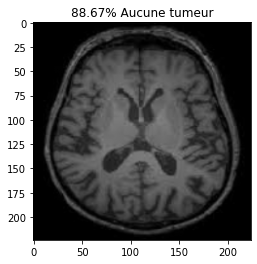

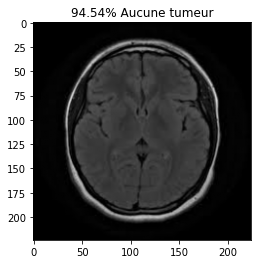

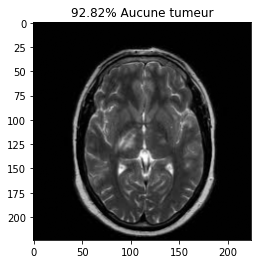

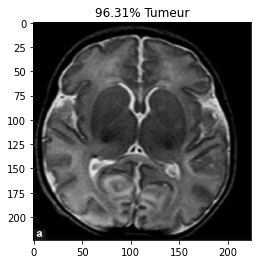

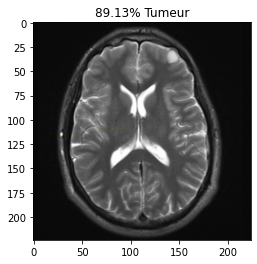

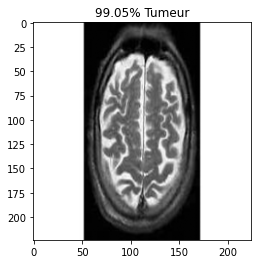

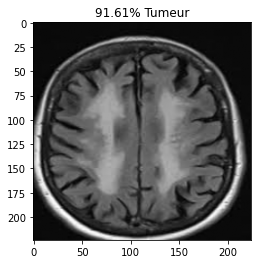

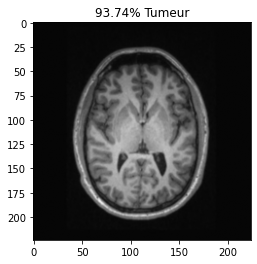

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)
# Réaliser une prédicton à partir d'un lot d'images de tests
prediction=y_pred[10:25]

for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Tumeur')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Aucune tumeur')
    plt.imshow(X_test[index])
    # Afficher les images
    plt.show()
    # Affiche la figure à l'écran

In [14]:
# Convert to Binary classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# np.argmax : Renvoie les indices des valeurs maximales le long d'un axe.

### Afficher la matrice de confusion : 

Confusion Matrix without Normalization


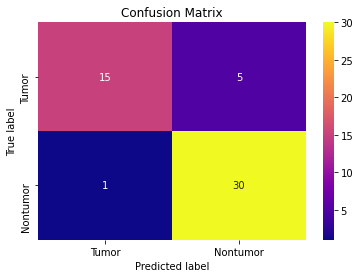

Confusion Matrix with Normalized Values


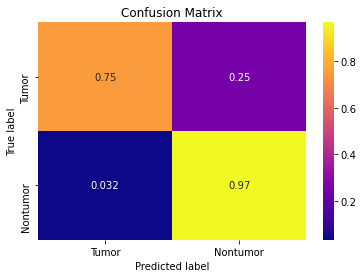

In [16]:
# La précision (accuracy) est le rapport entre les prédictions correctes et le total des prédictions faites.
# accuracy = correct_predictions / total_predictions * 100
# ou error rate = (1 -(correct_predictions / total_predictions)) * 100

# Suivant le nombre de classes et plus celui-ci augmente, la précision peut devenir une valeur trompeuse. 
# Effectivement, un bon score de prédition peut être inhérentes à certaines classes mais pas à d'autres.

# Pour remédier à cette problématique, l'utilisation d'une matrice de confusion propose un résumé des prédictions 
# correctes et incorrects de chacune des classes. Ainsi cette technique offre une meilleure description des performances 
# d'un algorithme de classification.

# y_test_bin : valeur des résultats attendues pour l'ensemble de données de test.
# y_pred_bin : valeur des prédictions pour l'ensemble de données de test.

# Comment lire une matrice de confusion :

# Plus les éléments proposés en diagonales (en haut à gauche vers le bas à droite) sont élevés pour une même classe, 
# plus les prédictions sont correctes. Les éléments en dehors de cette diagonale précisent que certaines prédicitions 
# sont au contraire mal étiquetés.

#             Prédiction
#            -------------
#           |  vn  |  fp  |      
#  réalité  -------------
#           |  fn  |  vp  |      
#           -------------

# vn : vrai négatif
# fp : faux positif
# fn : faux négatif
# vp : vrai positif

# Explications :

# vrai faux : indique si la prédiction est correcte ou non.
# negatif positif : indique le résultat de la prédiction.

# Ainsi par exemple les faux positifs sont tous ceux qui ont été prédits positif alors qu'ils ne le sont pas.

def plot_confusion_matrix(file_name, normalize, ):
    classes = ['Tumor','Nontumor']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_classes, y_pred_classes, normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix('vgg_tumor_confusion_matrix_without_normalization.png', normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix('vgg_tumor_confusion_matrix_with_normalization.png', normalize='true')

### **Tracé de précision et de perte**

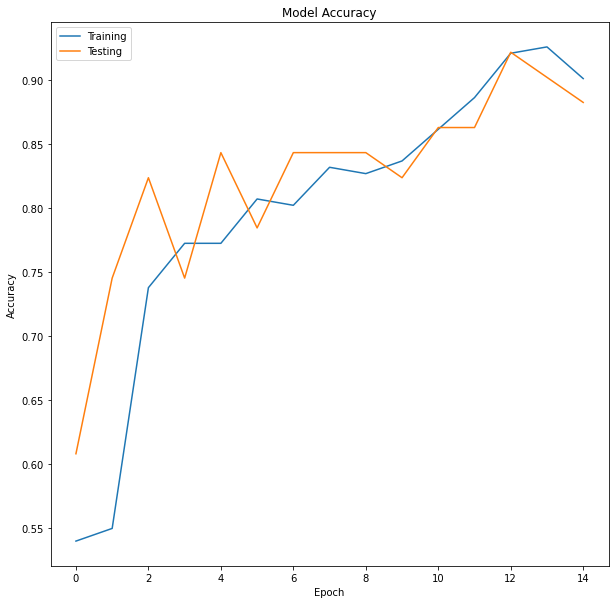

In [17]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_brain_accuracy.png')
plt.show()

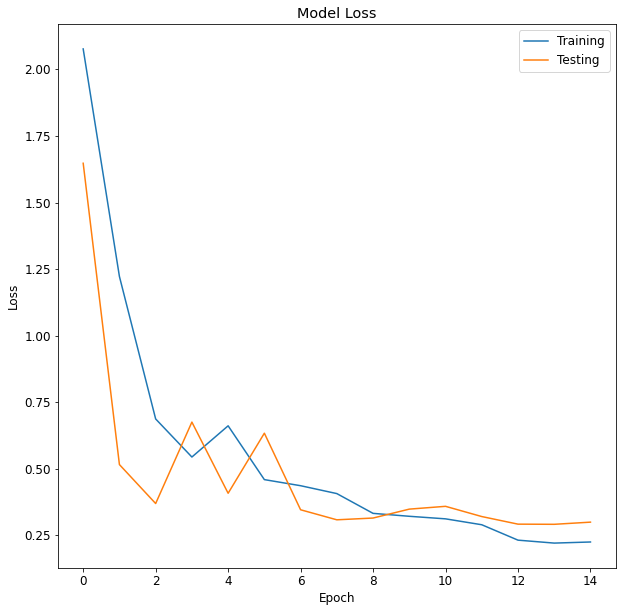

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_brain_loss.png')
plt.show()

### **Rapport de classification**

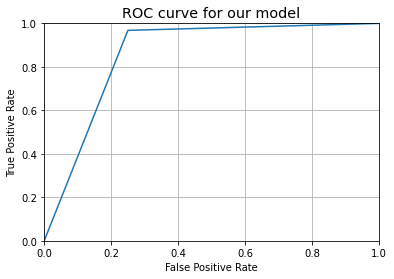

In [19]:
# Il s'agit d'une courbe établissant un rapport entre les faux positifs et les faux négatifs à partir d'un seuil, 
# le seuil est la probabilité à partir la prédiction est correcte.

# Cette courbe aide à comparer les modèles et à choisir un seuil optimal

fpr, tpr, thresholds = roc_curve(y_test_classes, y_pred_classes)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### **Classification Report**

In [23]:
# Accuracy est le rapport entre les bonnes prédictions et toutes les prédictions :
# accuracy = (vn + vp) / (vn + fp + fn + vp) 
 
# la precision est le nombre de de documents correctement attribuées à la classe i par rapport 
# au nombre total de documents prédits comme appartenant à la classe i
# precision = (vp/(vp + fp))
# la precision permet de mesurer le cout des faux positif qui devraient idéalement être à 1.

# Le recall ou sensibilité correspond au nombre de documents correctement attribués à la classe i 
# par rapport au nombre total de documents appartenant à la classe i.
# Ce calcul permet d'estimer combien de documents réellement positifs ont été capturer et combien
# sont passés au travers des mailles du filet.
Recall = (tp)/(tp + fn)

# Score F1 allie la précision et le rappel 

# F1-score = 2 * (precision * recall)/(precision + recall)

# Le F1-score ne prend donc pas en compte les vrai négatifs pouvant fausser la performance du modèle : l'accuracy.
# Le F1-score est donc à privilégier sur la precision en cas de classes déséquilibrées.

# macro avg : Calculez les métriques pour chaque étiquette et trouvez leur moyenne non pondérée. 
# Cela ne tient pas compte du déséquilibre des étiquettes.

# weighted avg : Calculez les métriques pour chaque étiquette et trouvez leur moyenne pondérée par le support (le nombre d'instances réelles pour chaque étiquette). 
# Cela modifie la « macro » pour tenir compte du déséquilibre de l'étiquette ; cela peut entraîner un score F qui n'est pas entre la précision et le rappel.

# Le support (le nombre d'instances réelles pour chaque étiquette)

# Source : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))



              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.86      0.97      0.91        31

    accuracy                           0.88        51
   macro avg       0.90      0.86      0.87        51
weighted avg       0.89      0.88      0.88        51

